# Nonlinear Buckling Analysis of the uCRM-9

After the nonlinear buckling analysis on the different box beam configurations and the investigation of their equilibrium paths, we are finally ready to study the nonlinear buckling behavior of the uCRM-9.

* [Setup of the numerical model](#numerical-model)
* [Linear buckling analysis](#linear-buckling)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

The uCRM-9 is a flexible version of NASA's Common Research Model (CRM, [Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)) developed by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603). The structural mesh files for the aluminum wingbox structure including material properties based on a smeared stiffness blade-stiffened panel approach can be found on [this Mendeley Data page](https://data.mendeley.com/datasets/gpk4zn73xn/1). Also the aerodynamic loads for the nominal 1g cruise and the run files for a linear static analysis (SOL 101) and a modal analysis (SOL 103) in Nastran are given in the same place.

To use the uCRM-9 model, we initialize a `BDF` object, create a case control deck requesting displacements and applied loads to be stored in the op2 file, and include the bdf file with the structural mesh of the wingbox in our object. The bdf file contains also the SPC cards defining the single point constraint applied to the model. For this reason we record the the id of the cards and add it to the case control deck.

In [48]:
from pyNastran.bdf.bdf import BDF
import os

# Initialize BDF object
ucrm9_bdf = BDF(debug=None)  

# Create case control deck
ucrm9_bdf.create_subcases(0)
ucrm9_bdf.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request no Bulk Data to be printed
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector

# Include structural mesh
ucrm9_bdf.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_wingbox_coarse.bdf'))  # structural model of the wingbox
spc_id = 1
ucrm9_bdf.case_control_deck.subcases[0].add_integer_type('SPC', spc_id)

subcase=0 already exists...skipping


Then we add some PARAM cards to replicate the settings prescribed in the original run files.

In [49]:
# Add PARAM cards
ucrm9_bdf.add_param('AUTOSPC', ['NO'])  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf.add_param('GRDPNT', [1])  # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf.add_param('K6ROT', [1e5])  # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf.add_param('COUPMASS', [-1])  # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the following elements: CBAR, CBEAM, CONROD, CQUAD4, CHEXA, CPENTA, CPYRAM, CQUAD8, CROD, CTETRA, CTRIA3, CTRlA6, CTRIAX6, CTUBE
ucrm9_bdf.add_param('MAXRATIO', [1e7])  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf.add_param('POST', [1])  # store results in a op2 file
ucrm9_bdf.add_param('WTMASS', [1.])  # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM     WTMASS      1.

In this notebook we want to use the aerodynamic load of the 1g cruise condition and scale it uniformly to analyze the nonlinear behavior of the uCRM-9 under a pseudo-aerodynamic load. For this reason we include the bdf file with the FORCE cards describing the 1g aerodynamic load in our `BDF` object and we record the id of the cards.

In [50]:
ucrm9_bdf.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_aero_forces_1.0g_coarse.bdf'))  # aerodynamic 1g load
force_id = 1

## Linear buckling analysis <a name="linear-buckling"></a>

***

 We run a linear buckling analysis with SOL 105 calling the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module. Then we find the critical buckling factor and we plot the associated buckling mode together with the maximum displacement occurs.

Nastran job linear_buckling.bdf completed
Wall time: 17.0 s


Buckling factor: 2.9


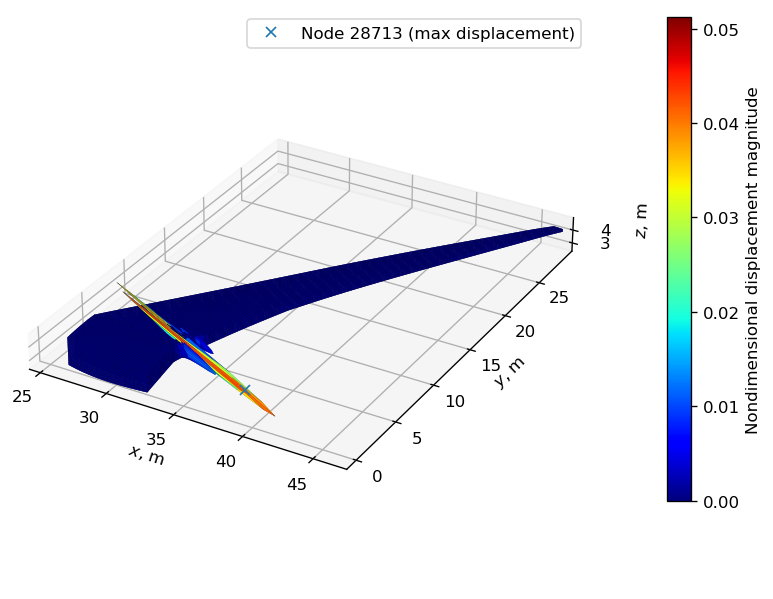

In [51]:
from resources import pynastran_utils
import matplotlib.pyplot as plt
import numpy as np

# Define analysis directory
analysis_directory_name = '17_Nonlinear_Buckling_Analysis_of_the_uCRM-9'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Run analysis
input_name = 'linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=ucrm9_bdf.__deepcopy__({}), static_load_set_id=force_id,
                                                            analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                            run_flag=False)

# Find critical buckling factor and print it
eigenvalue_calculation_subcase_id = 2
sol_105_buckling_factor = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling factor: {sol_105_buckling_factor:.1f}')

# Plot buckling mode
plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id,
                                              displacement_component='magnitude', colormap='jet', length_unit='m')
ax.locator_params(axis='x', nbins=8)  # set number of ticks of z-axis
ax.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .84))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(.05, .15))  # move colorbar upwards

# Plot max rotation node
max_rotation_index = np.argmax(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 5])
max_rotation_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[max_rotation_index, 0]
max_rotation_node_xyz = sol_105_op2.nodes[max_rotation_node_id].xyz + 200*sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[
    0, max_rotation_index, 0:3]
ax.plot(max_rotation_node_xyz[0], max_rotation_node_xyz[1], max_rotation_node_xyz[2], 'x',
        label=f'Node {max_rotation_node_id:d} (max displacement)', zorder=4)
ax.legend()

# Show plot
plt.show()

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to investigate the sensitivity of the nonlinear analysis parameters of SOL 106. We set the applied load to twice the critical buckling load predicted by SOL 105. We do this by scaling the 1g aerodynamic load by the critical buckling factor multiplied by two. Then we set up SOL 106 with the arc-length method.

In [52]:
load_scale_factor = 2  # scale factor of buckling load
load_set_id = force_id + 1  # define id of load set
ucrm9_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*load_scale_factor], load_ids=[force_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
pynastran_utils.set_up_arc_length_method(ucrm9_bdf)  # set up SOL 106 with arc-length method using default parameters

Before moving on to the nonlinear analyses, we need to add an option to change all CQUADR cards into CQUAD4 cards, as SOL 106 cannot work with the former and can only work with the latter.

In [53]:
ucrm9_bdf.system_command_lines[0:0] = ['NASTRAN QRMETH=3']

### Error function <a name="error-function"></a>

We start our sensitivity study by looking at the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking. 

In [54]:
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

Next we define the function `plot_load_displacement_diagram` to run the Nastran analysis, read the load and displacement history from the op2 file and plot the load-displacement curve on a pre-defined figure. For the displacement we consider the tip displacement $u_{z, tip}$ and nondimensionalize it with the span of the uCRM-9, $b=58.75$ m.

In [55]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

tip_node_id = 11847
component_index = 2  # displacement and load along the z-axis
b = 58.76  # uCRM-9 wingspan [m]
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    step, _, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:, component_index]/b, step[1]*load_scale_factor, marker=marker_style, linestyle='-', label=line_label)

We run the analyses with the different error functions and plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 411.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 410.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 423.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 393.0 s


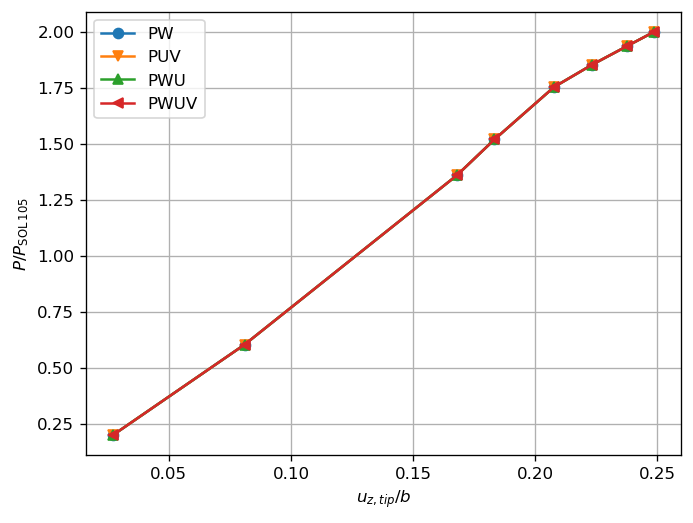

In [56]:
nlparm_id = next(iter(ucrm9_bdf.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    ucrm9_bdf.nlparms[nlparm_id].conv = fun
    input_name = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(ucrm9_bdf, input_name, ax, markers[count], f'{fun}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The load-diaplcement diagram appears to be significantly nonlinear, with an initial stiffening response followed by a softening behavior. However, this observation is very preliminary, as the employed arc-length size is very large. As far as the error functions are concerned, they do not seem to affect the results in terms of load-displacement curve. As a consequence, we restore the default parameter.

In [57]:
ucrm9_bdf.nlparms[nlparm_id].conv = 'PW'

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and energy tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $EPSP=10^{-1}$, $EPSW=10^{-1}$;
- $EPSP=10^{-2}$, $EPSW=10^{-3}$;
- $EPSP=10^{-3}$, $EPSW=10^{-7}$,

where the default values are $EPSP=10^{-2}$ and $EPSW=10^{-2}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 922.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 373.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 455.0 s


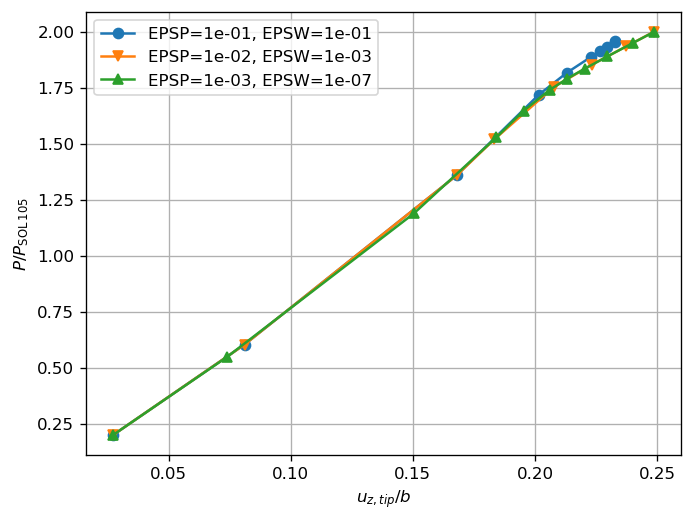

In [58]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    ucrm9_bdf.nlparms[nlparm_id].eps_p = epsp
    ucrm9_bdf.nlparms[nlparm_id].eps_w = epsw
    input_name = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'
    plot_load_displacement_curve(ucrm9_bdf, input_name, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The blue points appear to describe a different equilibrium path with respect to the other points. Let's check whether the difference is due to the looser convergence tolerances or if it is actually because the solver has jumped to an equilibrium path different from the natural one.

We define two subcases, similarly to our last notebooks.

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, MAXBIS=10, MINALR=0.01$;
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

In the first subcase we increase the maximum number of bisections for each load increment and the minimum arc-length adjustment ratio because the analysis failed to achieve convergence close to $P/P_\text{SOL 105}=2$, as it can be observed in the plot above. In the second subcase we use $\Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

In [59]:
# Modify first subcase
ucrm9_bdf.nlparms[nlparm_id].eps_p = 1e-1  # load tolerance
ucrm9_bdf.nlparms[nlparm_id].eps_w = 1e-1  # work tolerance
ucrm9_bdf.nlparms[nlparm_id].max_bisect = 10  # maximum number of bisections
ucrm9_bdf.nlpcis[nlparm_id].minalr = .01  # minimum arc-length ratio

# Create second subcase
zero_load_set_id = load_set_id + 1  # id of LOAD card
ucrm9_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_id])  # add LOAD card with zero applied load
unloading_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=ucrm9_bdf, nlparm_id=unloading_subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100,
                                         desiter=5, maxalr=1.01, maxinc=100, subcase_id=unloading_subcase_id)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis tracking the 10 lowest eigenvalues of the tangent stiffness matrix. For this we call the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynastran_utils` module.

In [60]:
method_set_id = zero_load_set_id + 1
no_eigenvalues = 10
input_name = 'path_existence_verification_epsp1e-1'
sol_106_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=ucrm9_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=True)

Nastran job path_existence_verification_epsp1e-1.bdf completed
Wall time: 6309.0 s


Now we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix. For this reason, we define the functions `plot_load_displacement_diagram` and `plot_tangent_stiffness_matrix_eigenvalues`. We use the first to plot the applied load against the nondimensional tip displacement, $u_{z, tip}/b$, and the second to plot the eigenvalues of the tangent stiffness matrix $\lambda$ against the iteration number and the applied load.

In [61]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

# Find overall critical buckling load magnitude - needed to nondimensionalize the applied load
applied_load_magnitude = np.linalg.norm(np.apply_along_axis(np.sum, 1, sol_105_op2.load_vectors[1].data[:, :, 0:3]))
sol_105_buckling_load_magnitude = applied_load_magnitude*sol_105_buckling_factor

# Define function to plot load-displacement diagram
def plot_load_displacement_diagram(disp, loads):
    # Create figure with one subplot
    load_displacement_ax = plt.subplot()
    # Plot nondimensional applied load vs nondimensional tip displacement for each subcase
    for subcase_id in disp:
        load_displacement_ax.plot(disp[subcase_id][:, component_index]/b, np.apply_along_axis(
            np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude, marker=markers[subcase_id - 1],
            label=f'Subcase {subcase_id:d}')
    # Set plot appearance
    load_displacement_ax.legend()  # set up legend
    plt.xlabel('$u_{z, tip}/b$')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

# Define function to plot the eigenvalue diagram
def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    # Discern lowest eigenvalues by subcase and plot them
    iterations_count = 1
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase_id in loads:  # iterate over subcases
        no_load_steps = len(loads[subcase_id])  # find number of load steps in current subcase
        eigenvalues_by_subcase[subcase_id] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]  # find eigenvalues of current subcase
        eigenvalues_count += no_load_steps  # update count of eigenvalues sorted so far
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase_id].shape[1] + iterations_count),
                            eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1],
                            label=f'Subcase {subcase_id:d}')
        iterations_count += eigenvalues_by_subcase[subcase_id].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(np.apply_along_axis(np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude,
                            eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\lambda$, N/m')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's call the defined functions and plot our results now.

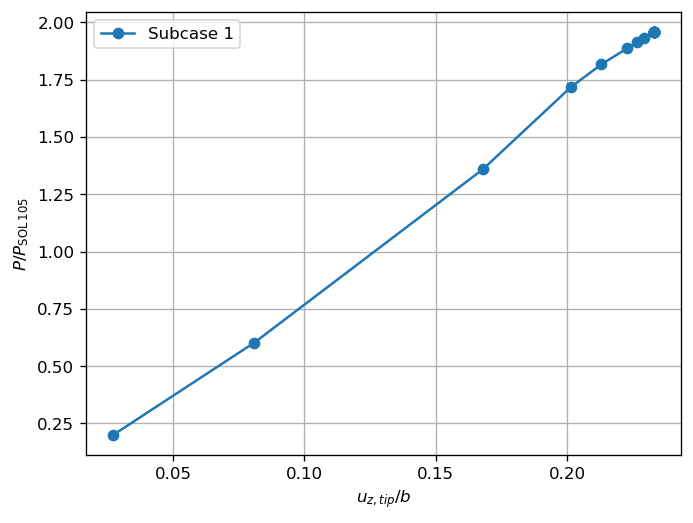

ValueError: x and y must have same first dimension, but have shapes (20,) and (19, 10)

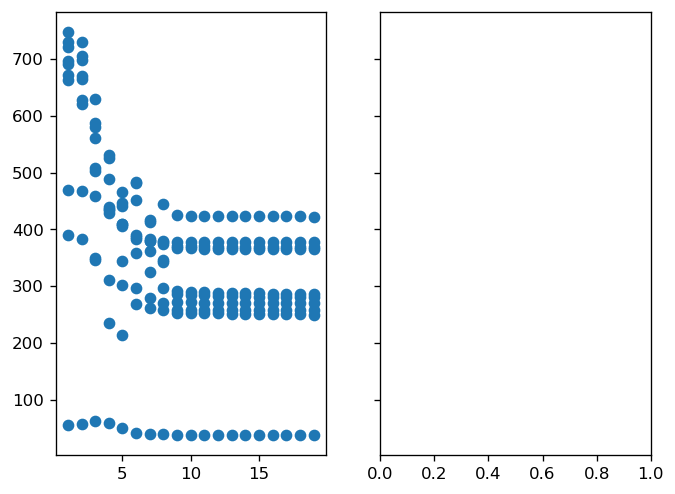

In [62]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_output,
                                                                                              displacement_node_id=tip_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads)

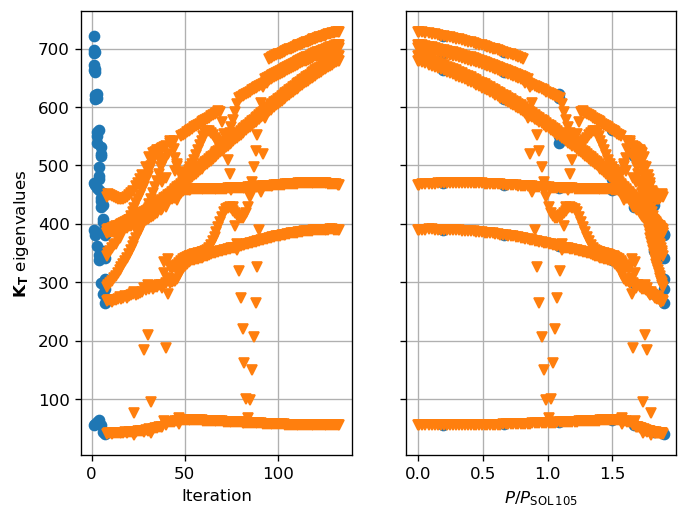

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, filename, loads):
    # Read eigenvalues
    f06_path = os.path.join(directory_path, filename + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase_id in loads:
        no_load_steps = len(loads[subcase_id])
        eigenvalues_by_subcase[subcase_id] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase_id].shape[1] + iterations_count), eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1], label=f'Subcase {subcase_id:d}')
        iterations_count += eigenvalues_by_subcase[subcase_id].shape[1]
        # Plot eigenvalues vs applied load
        eigvals_axs[1].plot(np.apply_along_axis(np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude, eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1])
    # Set plot appearance
    # axs[0].legend()
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

1. Aero load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [17]:
for nl_id in range(1, 3):
    ucrm9_bdf_input.nlparms[nl_id].eps_p = 1e-3
    ucrm9_bdf_input.nlparms[nl_id].eps_w = 1e-7

In [18]:
input_filename = 'bifurcation_verification_epsp1e-3'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_epsp1e-3.bdf completed
Wall time: 1546.0 s


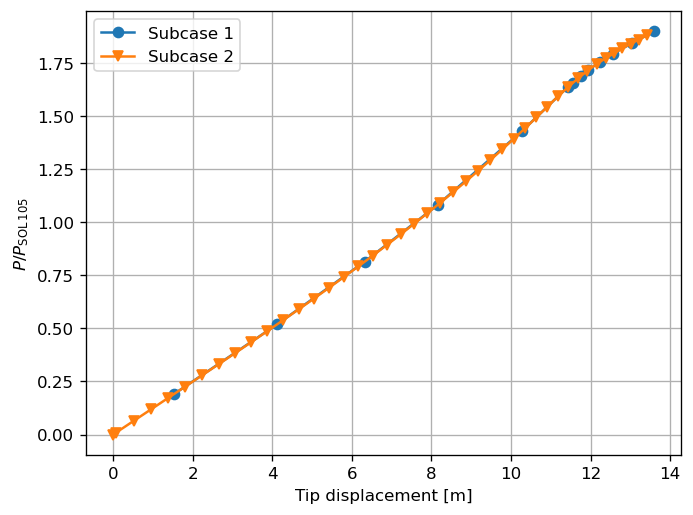

In [19]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements, applied_loads)

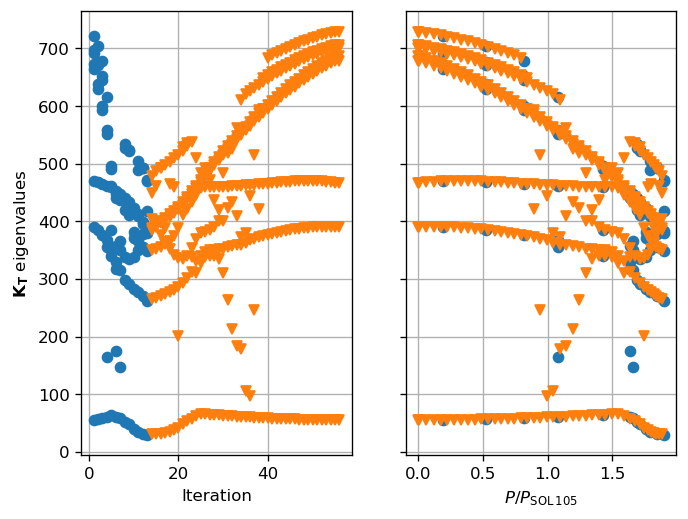

In [20]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Delete second subcase and set convergence tolerances.

In [21]:
del ucrm9_bdf_input.subcases[unloading_subcase_id]
for nl_id in range(1, 3):
    ucrm9_bdf_input.nlparms[nl_id].eps_p = 1e-1
    ucrm9_bdf_input.nlparms[nl_id].eps_w = 1e-1

Investigate effect of initial load increment.

Nastran job nonlinear_analysis_initial_load_increment_0_50.bdf completed
Wall time: 519.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_10.bdf completed
Wall time: 1651.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_01.bdf completed
Wall time: 1522.0 s


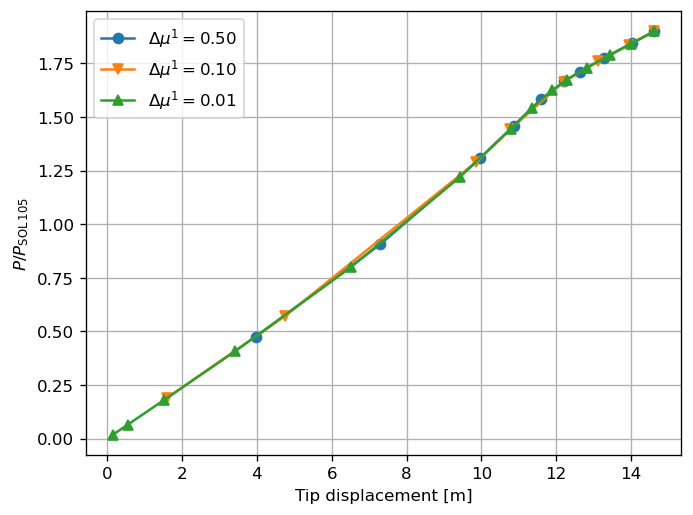

In [22]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    ucrm9_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Investigate effect of number of desired iterations.

In [23]:
ucrm9_bdf_input.nlparms[nlparm_id].ninc = 2

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 189.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 204.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 159.0 s


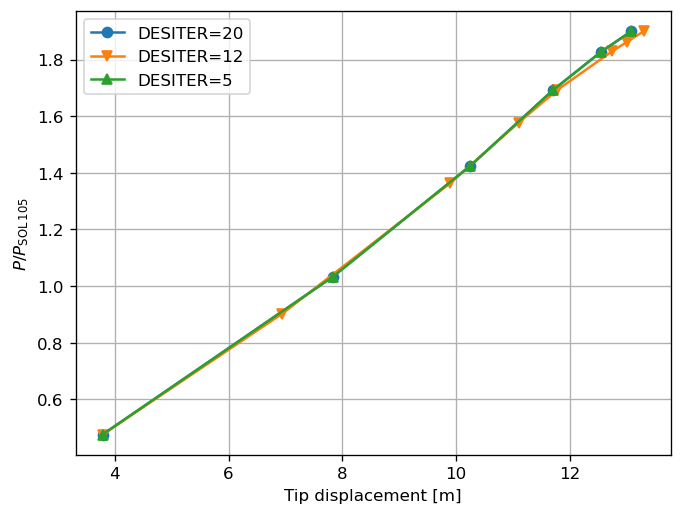

In [24]:
no_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_iterations):
    ucrm9_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = f'nonlinear_analysis_desiter_{desiter:.0f}'
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'DESITER={desiter}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.5, DESITER=20, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [25]:
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id, nlparm_id=unloading_subcase_id)  # create second subcase
ucrm9_bdf_input.nlpcis[nlparm_id].desiter = 20  # set number of desired iterations in first subcase

Nastran job bifurcation_verification_desiter20.bdf completed
Wall time: 1157.0 s


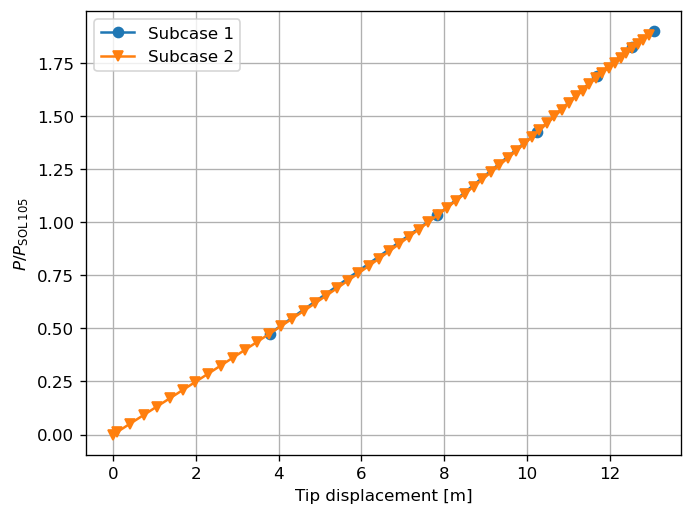

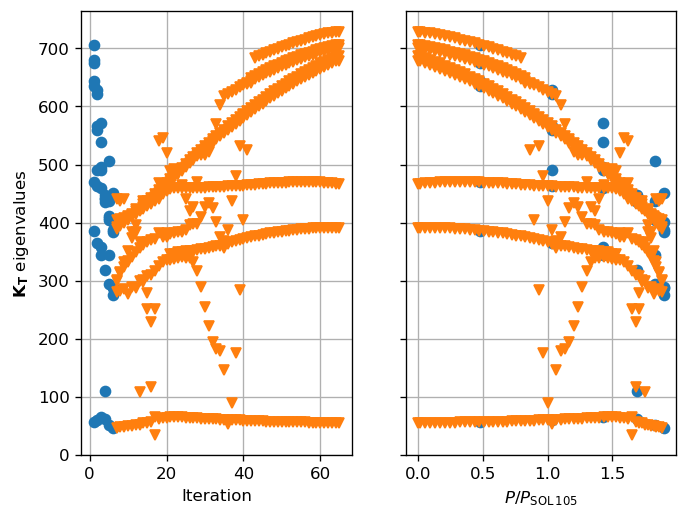

In [26]:
input_filename = 'bifurcation_verification_desiter20'
op2_output_desiter20 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)
_, applied_loads_desiter20, tip_displacements_desiter20 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_desiter20, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements_desiter20, applied_loads_desiter20)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_desiter20)

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.5, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

Nastran job bifurcation_verification_desiter12.bdf completed
Wall time: 1107.0 s


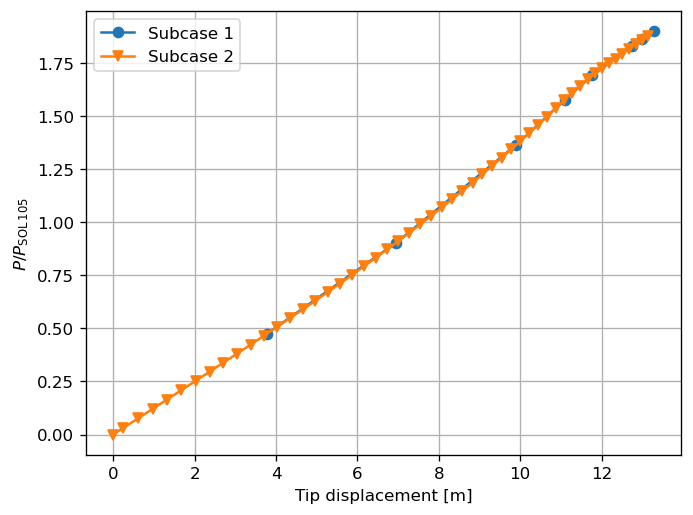

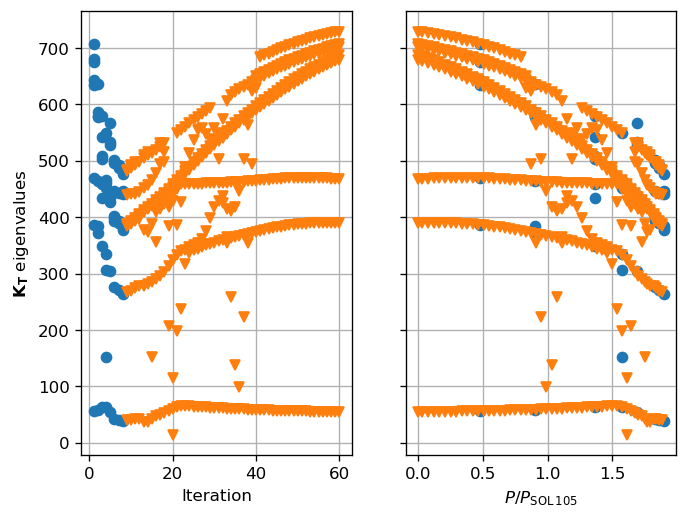

In [27]:
ucrm9_bdf_input.nlpcis[nlparm_id].desiter = 12  # set number of desired iterations in first subcase
input_filename = 'bifurcation_verification_desiter12'
op2_output_desiter12 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)
_, applied_loads_desiter12, tip_displacements_desiter12 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_desiter12, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements_desiter12, applied_loads_desiter12)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_desiter12)

Natural path.

In [28]:
# Change load of first subcase
load_scale_factor = 2
ucrm9_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_factor*load_scale_factor

# Set nonlinear analysis parameters
ucrm9_bdf_input.nlparms[unloading_subcase_id].eps_p = 1e-3
ucrm9_bdf_input.nlparms[unloading_subcase_id].eps_w = 1e-7
ucrm9_bdf_input.subcases[0].params['NLPARM'][0] = unloading_subcase_id

# Delete second subcase
del ucrm9_bdf_input.subcases[unloading_subcase_id]

In [29]:
input_filename = 'bifurcation_verification_natural_path'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=True)

Nastran job bifurcation_verification_natural_path.bdf completed
Wall time: 1853.0 s


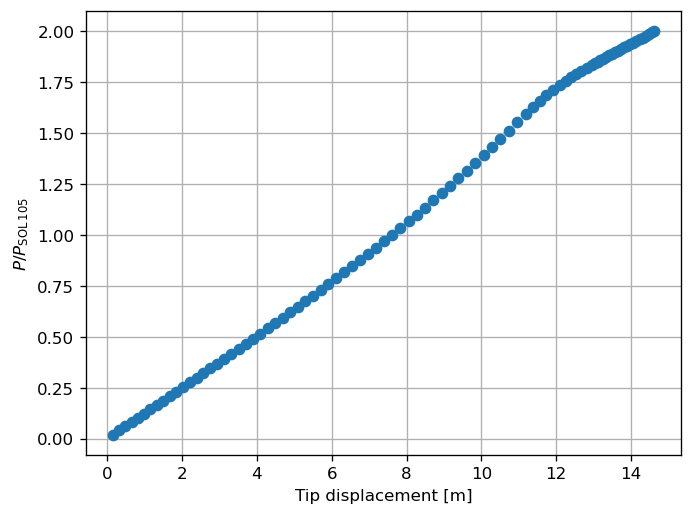

In [30]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_node_id)
applied_load_magnitude_history = np.apply_along_axis(np.linalg.norm, 1, applied_loads[1])

_, load_displacement_ax = plt.subplots()
load_displacement_ax.plot(tip_displacements[1][:, displacement_component_index], applied_load_magnitude_history/sol_105_buckling_load_magnitude, markers[0])
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

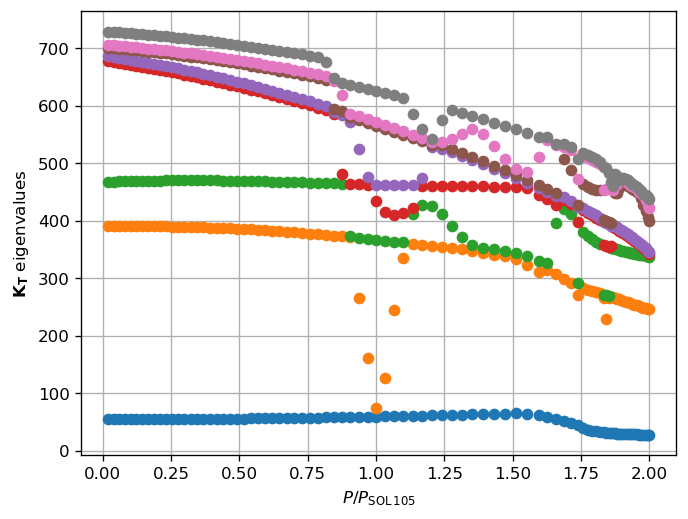

In [31]:
# Read eigenvalues of tangent stiffness matrix
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Plot lowest eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_load_magnitude_history/sol_105_buckling_load_magnitude, eigenvalues.T, markers[0])
ax.set_xlabel('$P/P_\mathrm{SOL\/105}$')
ax.set_ylabel('$\mathbf{K_T}$ eigenvalues')
ax.grid(visible=True)
plt.show()